In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')



In [2]:

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

print("Movies data shape:", movies.shape)
print("Ratings data shape:", ratings.shape)


Movies data shape: (62423, 3)
Ratings data shape: (25000095, 4)


In [3]:

movies.head()



,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [5]:

movie_data = pd.merge(ratings, movies, on='movieId')
movie_data.head()



,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,3,296,5.0,1439474476,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
2,4,296,4.0,1573938898,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,5,296,4.0,830786155,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
4,7,296,4.0,835444730,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


In [6]:

print(movie_data.describe())

print("\nMissing values:")
print(movie_data.isnull().sum())


             userId       movieId        rating     timestamp
count  2.500010e+07  2.500010e+07  2.500010e+07  2.500010e+07
mean   8.118928e+04  2.138798e+04  3.533854e+00  1.215601e+09
std    4.679172e+04  3.919886e+04  1.060744e+00  2.268758e+08
min    1.000000e+00  1.000000e+00  5.000000e-01  7.896520e+08
25%    4.051000e+04  1.196000e+03  3.000000e+00  1.011747e+09
50%    8.091400e+04  2.947000e+03  3.500000e+00  1.198868e+09
75%    1.215570e+05  8.623000e+03  4.000000e+00  1.447205e+09
max    1.625410e+05  2.091710e+05  5.000000e+00  1.574328e+09

Missing values:
userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64


In [7]:

n_users = movie_data['userId'].nunique()
n_movies = movie_data['movieId'].nunique()
print(f"Total unique users: {n_users}")
print(f"Total unique movies: {n_movies}")


Total unique users: 162541
Total unique movies: 59047


## Rating Distribution

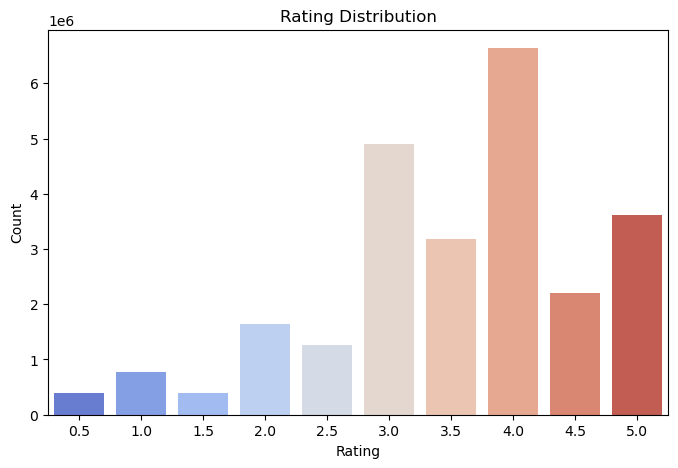

In [9]:

plt.figure(figsize=(8,5))
sns.countplot(x='rating', data=movie_data, palette='coolwarm')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


## Top 10 most rated movies

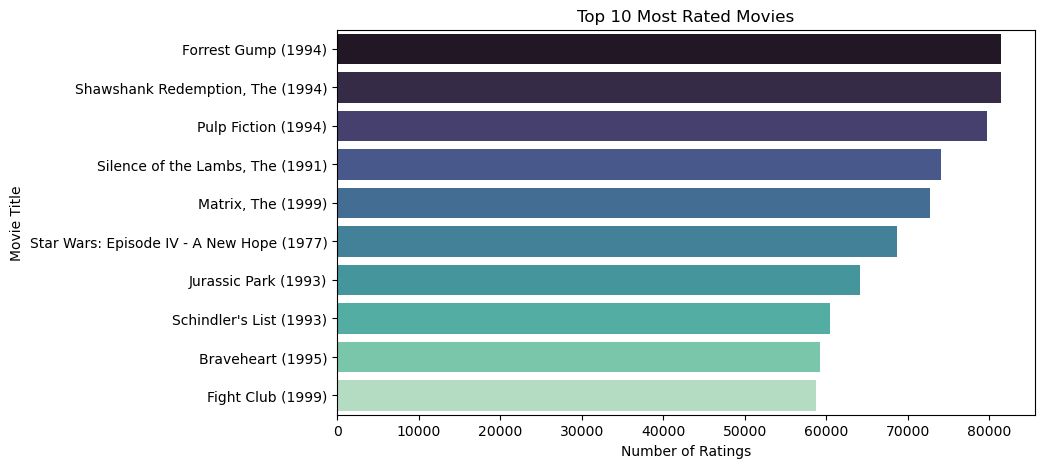

In [10]:

top_rated = movie_data.groupby('title')['rating'].count().sort_values(ascending=False).head(10)
plt.figure(figsize=(9,5))
sns.barplot(x=top_rated.values, y=top_rated.index, palette='mako')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()


## Movies with the highest average rating (min 50 ratings)

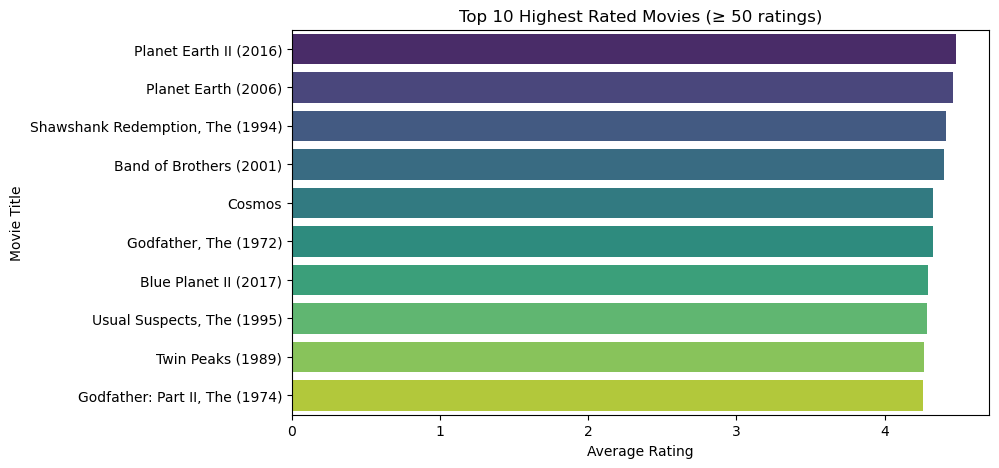

In [11]:

movie_new = movie_data.groupby('title').agg({'rating': ['mean', 'count']})
movie_new.columns = ['avg_rating', 'num_ratings']
popular_movies = movie_new[movie_new['num_ratings'] >= 50].sort_values(by='avg_rating', ascending=False).head(10)

plt.figure(figsize=(9,5))
sns.barplot(x=popular_movies['avg_rating'], y=popular_movies.index, palette='viridis')
plt.title('Top 10 Highest Rated Movies (≥ 50 ratings)')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.show()


## Keep only active users and popular movies

In [12]:

user_counts = movie_data['userId'].value_counts()
movie_counts = movie_data['movieId'].value_counts()

active_users = user_counts[user_counts >= 10].index
popular_movies = movie_counts[movie_counts >= 20].index

filtered_data = movie_data[movie_data['userId'].isin(active_users) &
                           movie_data['movieId'].isin(popular_movies)]

print("Before filtering:", movie_data.shape)
print("After filtering:", filtered_data.shape)


Before filtering: (25000095, 6)
After filtering: (24810483, 6)


## Encode IDs for matrix operations

In [13]:

user_to_index = {u: i for i, u in enumerate(filtered_data['userId'].unique())}
movie_to_index = {m: i for i, m in enumerate(filtered_data['movieId'].unique())}

filtered_data['user_idx'] = filtered_data['userId'].map(user_to_index)
filtered_data['movie_idx'] = filtered_data['movieId'].map(movie_to_index)

filtered_data.head()


,userId,movieId,rating,timestamp,title,genres,user_idx,movie_idx
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0,0
1,3,296,5.0,1439474476,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1,0
2,4,296,4.0,1573938898,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,2,0
3,5,296,4.0,830786155,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,3,0
4,7,296,4.0,835444730,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4,0


## Create sparse user–movie matrix

In [14]:

rating_matrix = csr_matrix(
    (filtered_data['rating'], (filtered_data['user_idx'], filtered_data['movie_idx']))
)

print("Sparse Matrix Shape:", rating_matrix.shape)
print("Non-zero entries:", rating_matrix.nnz)


Sparse Matrix Shape: (162541, 18430)
Non-zero entries: 24810483


In [15]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors


## Collaborative Filtering Model

In [17]:

print("\nBuilding Collaborative Filtering Model...")


cf_model = NearestNeighbors(metric='cosine', algorithm='brute')
cf_model.fit(rating_matrix)

def recommend_for_user(user_id, n_neighbors=5):
    
    if user_id not in user_to_index:
        return f"User {user_id} not found in dataset."
    
    user_idx = user_to_index[user_id]
    distances, neighbors = cf_model.kneighbors(
        rating_matrix.getrow(user_idx),
        n_neighbors=n_neighbors+1
    )
    
    similar_users_idx = neighbors.flatten()[1:]
    similar_users = [list(user_to_index.keys())[list(user_to_index.values()).index(i)] for i in similar_users_idx]
    
    
    similar_user_ratings = filtered_data[filtered_data['userId'].isin(similar_users)]
    top_movies = (
        similar_user_ratings.groupby('movieId')['rating']
        .mean()
        .sort_values(ascending=False)
        .head(10)
    )
    top_movie_titles = movies[movies['movieId'].isin(top_movies.index)]['title'].tolist()
    return top_movie_titles


example_user = list(user_to_index.keys())[10]
print(f"\nMovies recommended for user {example_user}:")
print(recommend_for_user(example_user))



Building Collaborative Filtering Model...

Movies recommended for user 15:
['Legends of the Fall (1994)', 'Wallace & Gromit: A Close Shave (1995)', 'Godfather, The (1972)', 'To Kill a Mockingbird (1962)', 'Glory (1989)', 'Man in the Iron Mask, The (1998)', 'Broadcast News (1987)', 'Buena Vista Social Club (1999)', 'Fatal Attraction (1987)', 'Donnie Darko (2001)']


## Check how popular recommended movies are

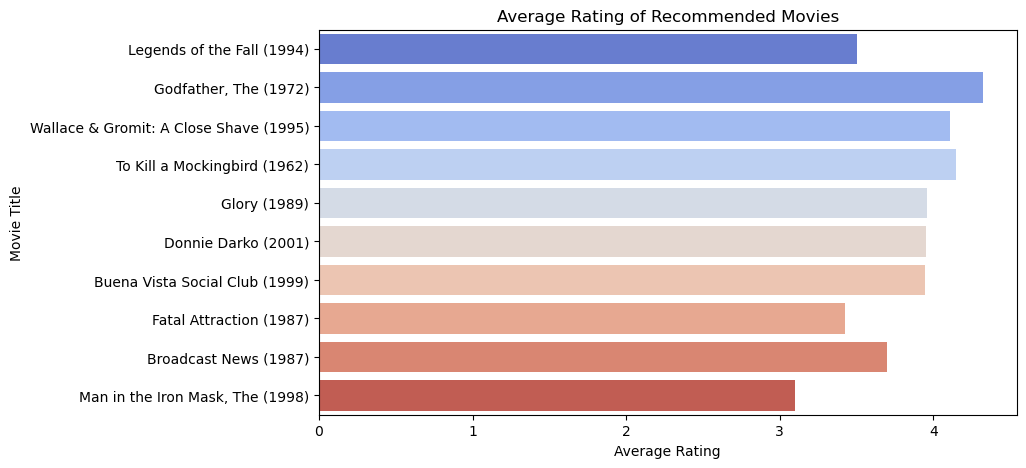

In [18]:

recommended_movies = recommend_for_user(example_user)
popularity_data = movie_data[movie_data['title'].isin(recommended_movies)]

plt.figure(figsize=(9,5))
sns.barplot(x='rating', y='title', data=popularity_data, estimator=np.mean, ci=None, palette='coolwarm')
plt.title('Average Rating of Recommended Movies')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.show()


## content-based recommender

In [16]:

print("Building Memory-Efficient Content-Based Recommendation Model...")

from sklearn.metrics.pairwise import linear_kernel


movies['genres'] = movies['genres'].fillna('')


tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])


indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

def recommend_by_genre(title, num_recommendations=5):
    if title not in indices:
        return ["Movie not found in database."]
    
    idx = indices[title]
    
    
    sim_scores = linear_kernel(tfidf_matrix[idx], tfidf_matrix).flatten()
    
    
    similar_indices = sim_scores.argsort()[-num_recommendations-1:-1][::-1]
    return movies['title'].iloc[similar_indices].tolist()


example_movie = "Toy Story (1995)"
print(f"\nMovies similar to '{example_movie}':")
print(recommend_by_genre(example_movie))


Building Memory-Efficient Content-Based Recommendation Model...

Movies similar to 'Toy Story (1995)':
['Missing Link (2019)', 'Toy Story Toons: Small Fry (2011)', 'Toy Story Toons: Hawaiian Vacation (2011)', 'Boxtrolls, The (2014)', 'Aladdin (1992)']


##  Popularity-Based Recommendation System

In [19]:

print("Building Popularity-Based Recommendation System...")



popularity_df = movie_new.reset_index()


popularity_df = popularity_df[popularity_df['num_ratings'] >= 100]


popular_movies = popularity_df.sort_values(by=['avg_rating', 'num_ratings'], ascending=False)


print("\n🎬 Top 10 Popular Movies:")
print(popular_movies.head(10))


Building Popularity-Based Recommendation System...

🎬 Top 10 Popular Movies:
                                  title  avg_rating  num_ratings
36804            Planet Earth II (2016)    4.483096         1124
36803               Planet Earth (2006)    4.464797         1747
41782  Shawshank Redemption, The (1994)    4.413576        81482
4934            Band of Brothers (2001)    4.398599         1356
11020                            Cosmos    4.326715          277
19301             Godfather, The (1972)    4.324336        52498
7005              Blue Planet II (2017)    4.289833          659
55289        Usual Suspects, The (1995)    4.284353        55366
54559                 Twin Peaks (1989)    4.267361          288
19302    Godfather: Part II, The (1974)    4.261759        34188


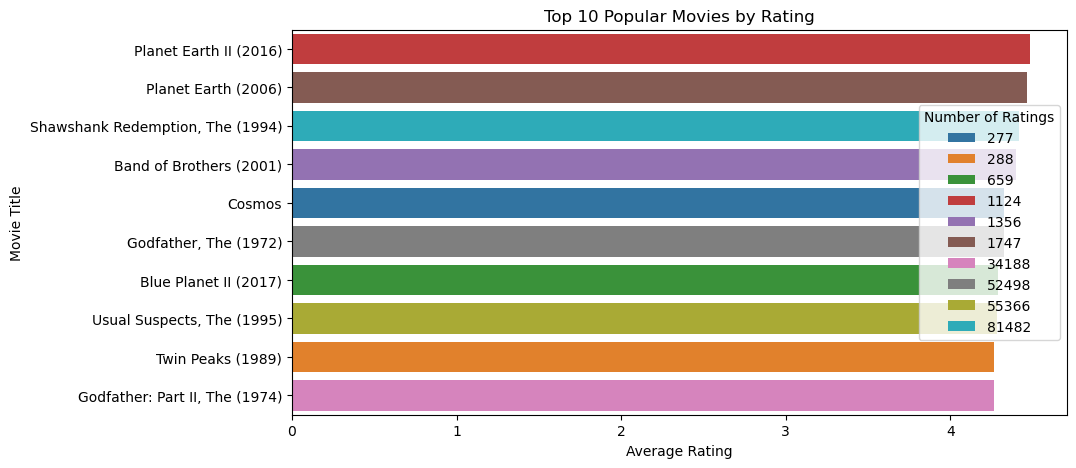

In [20]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=popular_movies.head(10),
    x='avg_rating',
    y='title',
    hue='num_ratings',
    dodge=False
)
plt.title("Top 10 Popular Movies by Rating")
plt.xlabel("Average Rating")
plt.ylabel("Movie Title")
plt.legend(title='Number of Ratings')
plt.show()
